## 1. Introduction

Notebook for generating lyrics using LSTM network. The dataset contains all the songs recorded by Bob Dylan. Stages:
1. EDA
    - Summary statistics on dataset: distribution of no. of characters, words, sentences in collection
    - Histograms & wordclouds
2. Preprocessing
    - Create corpus of all words from lyrics
    - Cleaning: remove special characters, convert to lowercase
    - Create mapping of unique chars to indices
    - Create features and targets (categorical)
3. Model
    - Train LSTM model, one character at a time
    - Visualize learning and loss
4. Generation
    - Generate lyrics from seed phrase, one character at a time, using model predictions

In [5]:
# Imports
# Core
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os, sys, warnings, random, io
warnings.filterwarnings("ignore")

# NLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import nltk
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont

In [6]:
# TPU config (for LSTM)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-03-12 16:41:13.122050: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-12 16:41:13.124940: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-12 16:41:13.125004: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-12 16:41:13.125035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (313b969c6652): /proc/driver/nvidia/version does not exist
2022-03-12 16:41:13.128217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

<a id="2"></a>
## 2. EDA

In [7]:
# Load song lyrics dataset
df_songs = pd.read_csv("../input/bob-dylan-songs/clear.csv")

data = pd.read_csv("../input/lyrics/Songs.csv")
df_songs = data[data.Artist=='Taylor Swift']
df_songs.reset_index(drop=True, inplace=True)
df_songs = df_songs.loc[:, ['Title', 'Lyrics']].rename(columns={'Title': 'title', 'Lyrics': 'lyrics'})

In [8]:
df_songs.head()

,release_year,album,title,lyrics
0,1961,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Hard Times In New York Town,"Come you ladies and you gentlemen, a-listen to..."
1,1961,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Man on the street,"’ll sing you a song, ain’t very long\n\n’Bout ..."
2,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Talkin’ Bear Mountain Picnic Massacre Blues,I saw it advertised one day\n\nBear Mountain p...
3,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Let Me Die in My Footsteps,I will not go down under the ground\n\n’Cause ...
4,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...","Rambling, Gambling Willie",Come around you rovin’ gamblers and a story I ...


In [9]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   release_year  345 non-null    int64 
 1   album         345 non-null    object
 2   title         345 non-null    object
 3   lyrics        345 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.9+ KB


### 2.1 Summary stats

In [10]:
# Get numbers of characters,words and sentences in each song
df_songs["n_chars"] = df_songs["lyrics"].apply(len)
df_songs["n_words"]=df_songs.apply(lambda row: nltk.word_tokenize(row["lyrics"]), axis=1).apply(len)
df_songs["n_lines"] = df_songs["lyrics"].str.split('\n').apply(len)
df_songs.describe()

,release_year,n_chars,n_words,n_lines
count,345.000000,345.000000,345.000000,345.000000
mean,1979.486957,1593.336232,351.159420,92.321739
std,15.441393,992.046017,214.159907,53.067621
min,1961.000000,75.000000,11.000000,3.000000
25%,1966.000000,1003.000000,220.000000,57.000000
50%,1975.000000,1330.000000,299.000000,81.000000
75%,1988.000000,1867.000000,416.000000,108.000000
max,2020.000000,8938.000000,1884.000000,448.000000


<AxesSubplot:xlabel='n_lines', ylabel='Count'>

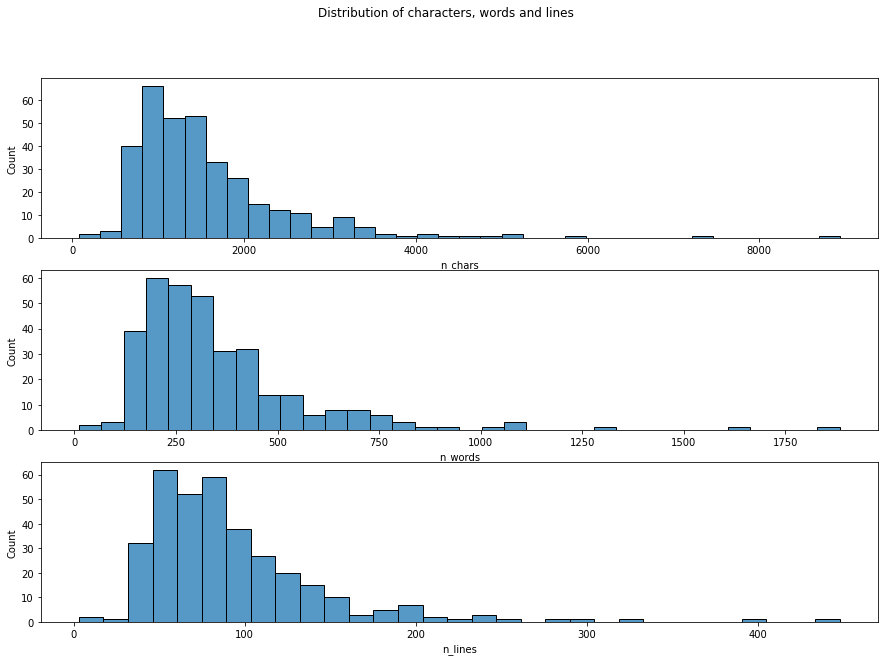

In [11]:
# Plot distribution of chars, words, sentences in lyrics
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Distribution of characters, words and lines')
sns.histplot(data=df_songs, x='n_chars', ax=axs[0])
sns.histplot(data=df_songs, x='n_words', ax=axs[1])
sns.histplot(data=df_songs, x='n_lines', ax=axs[2])

### 2.2 Wordcloud

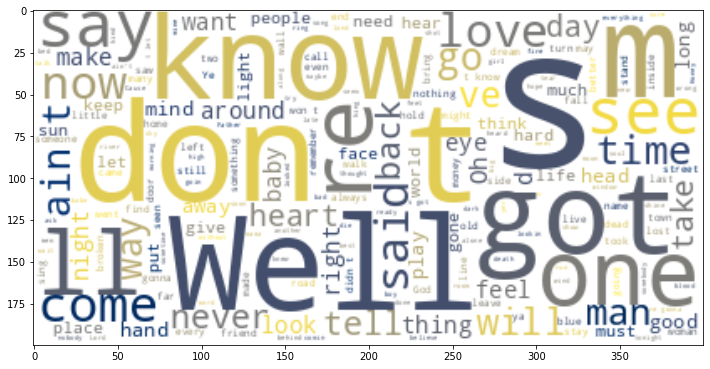

In [12]:
# Generate a wordcloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white",colormap="cividis", max_words=500).generate(" ".join(df_songs["lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [13]:
# Sample lyrics
song_idx = 10
print(df_songs.loc[song_idx, :])
df_songs.loc[song_idx, 'lyrics'].split('\n')

release_year                                                 1963
album           The Bootleg Series, Vol 1-3: Rare & Unreleased...
title                           Talkin’ John Birch Paranoid Blues
lyrics          Well, I was feelin’ sad and feelin’ blue\n\nI ...
n_chars                                                      2251
n_words                                                       502
n_lines                                                       124
Name: 10, dtype: object


['Well, I was feelin’ sad and feelin’ blue',
 '',
 'I didn’t know what in the world I wus gonna do',
 '',
 'Them Communists they wus comin’ around',
 '',
 'They wus in the air',
 '',
 'They wus on the ground',
 '',
 'They wouldn’t gimme no peace . . .',
 '',
 '',
 '',
 'So I run down most hurriedly',
 '',
 'And joined up with the John Birch Society',
 '',
 'I got me a secret membership card',
 '',
 'And started off a-walkin’ down the road',
 '',
 'Yee-hoo, I’m a real John Bircher now!',
 '',
 'Look out you Commies!',
 '',
 '',
 '',
 'Now we all agree with Hitler’s views',
 '',
 'Although he killed six million Jews',
 '',
 'It don’t matter too much that he was a Fascist',
 '',
 'At least you can’t say he was a Communist!',
 '',
 'That’s to say like if you got a cold you take a shot of malaria',
 '',
 '',
 '',
 'Well, I wus lookin’ everywhere for them gol-darned Reds',
 '',
 'I got up in the mornin’ ’n’ looked under my bed',
 '',
 'Looked in the sink, behind the door',
 '',
 'Looked in t

## 3. Preprocessing

In [14]:
df_songs.shape

(345, 7)

### 3.1 Create corpus

In [30]:
# Create corpus from lyrics
corpus = ''
for text in df_songs.lyrics:
    corpus += text
    
corpus = corpus.lower()
print("Number of unique characters:", len(set(corpus)))

Number of unique characters: 65


###  3.2 Cleaning

In [31]:
print(sorted(set(corpus)))

['\n', '\x0b', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¥', '©', 'é', 'ñ', 'ó', 'ü', '–', '—', '‘', '’', '“', '”', '…', '\u2028']


In [32]:
special_chars = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '“', '”', '`'
             '…', '\x0b', '\u2028', '&', '(', ')', '*', '-',  '/', ]
for symbol in special_chars:
    corpus = corpus.replace(symbol,"")
# Corpus = re.sub("[^A-Za-z'\.\n\w\']","",Corpus)

In [33]:
print(sorted(set(corpus)))

['\n', ' ', '!', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¥', '‘', '’', '…']


In [34]:
# Sample section
corpus[:1000]

'come you ladies and you gentlemen, alisten to my song\n\nsing it to you right, but you might think it’s wrong\n\njust a little glimpse of a story i’ll tell\n\n’bout an east coast city that you all know well\n\nit’s hard times in the city\n\nlivin’ down in new york town\n\n\n\nold new york city is a friendly old town\n\nfrom washington heights to harlem on down\n\nthere’s amighty many people all millin’ all around\n\nthey’ll kick you when you’re up and knock you when you’re down\n\nit’s hard times in the city\n\nlivin’ down in new york town\n\n\n\nit’s a mighty long ways from the golden gate\n\nto rockefeller plaza ’n’ the empire state.\n\nmister rockefeller sets up as high as a bird\n\nold mister empire never says a word\n\nit’s hard times from the country\n\nlivin’ down in new york town\n\n\n\nwell, it’s up in the mornin’ tryin’ to find a job of work\n\nstand in one place till your feet begin to hurt\n\nif you got a lot o’ money you can make yourself merry\n\nif you only got a nickel

<a id="3.3"></a>
### 3.3 Create inputs from mapping

In [35]:
# Map characters in corpus to indices
symb = sorted(list(set(Corpus)))

len_corpus = len(Corpus) 
len_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", len_corpus)
print("Number of unique characters:", len_symb)

Total number of characters: 541468
Number of unique characters: 47


In [36]:
#Splitting the corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, len_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
len_datapoints = len(targets)
print("Total number of sequences in the Corpus:", len_datapoints)

Total number of sequences in the Corpus: 541428


In [37]:
# reshape X and normalize
X = (np.reshape(features, (len_datapoints, length, 1)))/ float(len_symb)

# one hot encode the output variable
y = to_categorical(targets)

## 4. Model

### 4.1 Training

In [38]:
#Initialising the Model
with tpu_strategy.scope():
    model = Sequential()
    model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 47)                12079     
Total params: 276,271
Trainable params: 276,271
Non-trainable params: 0
_________________________________________________________________


In [39]:
%%time
#Training the Model
history = model.fit(X, y, batch_size=256*tpu_strategy.num_replicas_in_sync, epochs=50)

Epoch 1/50
265/265 [==============================] - 9s 15ms/step - loss: 3.0338
Epoch 2/50
265/265 [==============================] - 3s 13ms/step - loss: 2.8120
Epoch 3/50
265/265 [==============================] - 3s 12ms/step - loss: 2.7308
Epoch 4/50
265/265 [==============================] - 3s 12ms/step - loss: 2.6642
Epoch 5/50
265/265 [==============================] - 3s 12ms/step - loss: 2.6188
Epoch 6/50
265/265 [==============================] - 3s 12ms/step - loss: 2.5783
Epoch 7/50
265/265 [==============================] - 3s 13ms/step - loss: 2.5482
Epoch 8/50
265/265 [==============================] - 3s 13ms/step - loss: 2.5280
Epoch 9/50
265/265 [==============================] - 3s 12ms/step - loss: 2.5016
Epoch 10/50
265/265 [==============================] - 3s 13ms/step - loss: 2.4878
Epoch 11/50
265/265 [==============================] - 3s 13ms/step - loss: 2.4656
Epoch 12/50
265/265 [==============================] - 3s 12ms/step - loss: 2.4486
Epoch 13/50
2

In [40]:
model.save("generator_1.h5")

### 4.2 Evaluation

[Text(0.5, 0, 'Epochs')]

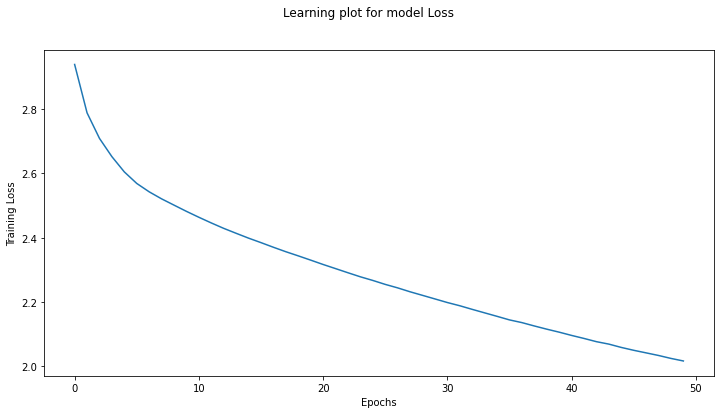

In [41]:
# Evaluation
history_df = pd.DataFrame(history.history)
#Plotting the learning curve

fig = plt.figure(figsize=(12,6))
fig.suptitle("Learning plot for model Loss")
pl = sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

## 5. Generation

In [44]:
# The function to generate text from model
def generate(starter,char_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(char_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(len_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [45]:
song = generate("the answer my friend, is blowi", 100)
song.split('\n')

['the answer my friend, is blowin in the wind',
 '',
 '',
 ' whlle yhu ao taet you',
 '',
 'toeelie to to the born',
 '',
 'gonl the dore whu seel me ',
 'in io toe']

In [46]:
song = generate("it's all over now, baby bl", 200)
song.split('\n')

["it's all over now, baby bl you teel?",
 '',
 '',
 '',
 'ie said, you gan to hr ko?e',
 '',
 '',
 '',
 'iu taed, d mort inr ao the ',
 '',
 '',
 '',
 ' ',
 ' ',
 ' well, i dndn gand to be ni toee',
 '',
 '',
 '',
 'whll you donn wo gr to ke',
 '',
 '',
 '',
 'io toer iort an the soree',
 '',
 '',
 '',
 'whlle yhu ao the borna thr']